In [1]:
%load_ext autoreload
%autoreload 2


- Two major problems
  - Spatial data (and others) has no fixed reference. There should be a transform/rot/scale lstsq after main pinning
  - There is no current incentive for cells to interact with an absolute env

In [2]:
import io
import logging
import os

import manim as ma
import matplotlib as mpl
from matplotlib.patches import ConnectionPatch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import sklearn
import torch
import umap

import celltrip

# No verbose cred grab
logging.getLogger('aiobotocore').setLevel(logging.CRITICAL)
logging.getLogger('fsspec').setLevel(logging.CRITICAL)
# logging.Logger.manager.loggerDict

# Environment
os.environ['AWS_PROFILE'] = 'waisman-admin'
mpl.rcParams['pdf.fonttype'] = mpl.rcParams['ps.fonttype'] = 42
sns.set_theme(context='paper', style='dark', palette='colorblind')


# Running the Model

In [3]:
# Read data files
adatas = celltrip.utility.processing.read_adatas(
    's3://nkalafut-celltrip/dyngen/logcounts.h5ad',
    's3://nkalafut-celltrip/dyngen/counts_protein.h5ad',
    backed=True)
# Model location and name (should contain .weights, .pre, and .mask file)
# prefix, training_step = 's3://nkalafut-celltrip/checkpoints/Dyngen-250920', 800
prefix, training_step = 's3://nkalafut-celltrip/checkpoints/Dyngen-251015', 800  # 32 dim
# Generate or load preprocessing
preprocessing = celltrip.utility.processing.Preprocessing().load(f'{prefix}.pre')
with celltrip.utility.general.open_s3_or_local(f'{prefix}.mask', 'rb') as f:
    content = f.read()
    mask = np.loadtxt(io.BytesIO(content)).astype(bool)
# Subset and preprocess the data (Use partition cols here to select data)
samples = adatas[0].obs.index
m1, m2 = preprocessing.transform([ad[samples].X for ad in adatas])
# Initialize environment and policy
env = celltrip.environment.EnvironmentBase(
    torch.tensor(m1), torch.tensor(m2), target_modalities=None, dim=32).eval().to('cuda')
# env.set_modalities(...); env.reset()  # Change modalities
policy = celltrip.policy.create_agent_from_env(env).eval().to('cuda')  # pinning_modal_dims=None for lstq pinning
policy.load_checkpoint(f'{prefix}-{training_step:04}.weights');


In [4]:
# # Read data files
# adatas = celltrip.utility.processing.read_adatas(
#     's3://nkalafut-celltrip/MERFISH/expression.h5ad',
#     's3://nkalafut-celltrip/MERFISH/spatial.h5ad',
#     backed=True)
# # Model location and name (should contain .weights, .pre, and .mask file)
# prefix, training_step = 's3://nkalafut-celltrip/checkpoints/MERFISH-250825', 400
# # Generate or load preprocessing
# preprocessing = celltrip.utility.processing.Preprocessing().load(f'{prefix}.pre')
# with celltrip.utility.general.open_s3_or_local(f'{prefix}.mask', 'rb') as f:
#     mask = np.loadtxt(f).astype(bool)
# # Subset and preprocess the data (Use partition cols here to select data)
# samples = adatas[0].obs.index
# m1, m2 = preprocessing.transform([ad[samples].X for ad in adatas])
# # Initialize environment and policy
# env = celltrip.environment.EnvironmentBase(
#     torch.tensor(m1), torch.tensor(m2), target_modalities=[1], dim=8).eval().to('cuda')
# # env.set_modalities(...); env.reset()  # Change modalities
# policy = celltrip.policy.create_agent_from_env(env, pinning_spatial=[1]).eval().to('cuda')  # pinning_modal_dims=None for lstq pinning
# policy.load_checkpoint(f'{prefix}-{training_step:04}.weights', strict=False);


In [5]:
# # Read data files
# adatas = celltrip.utility.processing.read_adatas(
#     's3://nkalafut-celltrip/MERFISH_Bench/expression.h5ad',
#     's3://nkalafut-celltrip/MERFISH_Bench/spatial.h5ad',
#     backed=True)
# # Model location and name (should contain .weights, .pre, and .mask file)
# prefix, training_step = 's3://nkalafut-celltrip/checkpoints/MERFISH_Bench-250807', 300
# # Generate or load preprocessing
# preprocessing = celltrip.utility.processing.Preprocessing().load(f'{prefix}.pre')
# with celltrip.utility.general.open_s3_or_local(f'{prefix}.mask', 'rb') as f:
#     mask = np.loadtxt(f).astype(bool)
# # Subset and preprocess the data (Use partition cols here to select data)
# samples = adatas[0].obs.index
# m1, m2 = preprocessing.transform([ad[samples].X for ad in adatas])
# # Initialize environment and policy
# env = celltrip.environment.EnvironmentBase(
#     torch.tensor(m1), torch.tensor(m2), target_modalities=[1], dim=8).eval().to('cuda')
# # env.set_modalities(...); env.reset()  # Change modalities
# policy = celltrip.policy.create_agent_from_env(env).eval().to('cuda')  # pinning_modal_dims=None for lstq pinning
# policy.load_checkpoint(f'{prefix}-{training_step:04}.weights');


In [6]:
# # Read data files
# adatas = celltrip.utility.processing.read_adatas(
#     's3://nkalafut-celltrip/MERFISH30k/expression.h5ad',
#     's3://nkalafut-celltrip/MERFISH30k/spatial.h5ad',
#     backed=True)
# # Model location and name (should contain .weights, .pre, and .mask file)
# prefix, training_step = 's3://nkalafut-celltrip/checkpoints/MERFISH30k-153-250914', 800
# # prefix, training_step = 's3://nkalafut-celltrip/checkpoints/MERFISH30k-250830', 800
# # Generate or load preprocessing
# preprocessing = celltrip.utility.processing.Preprocessing().load(f'{prefix}.pre')
# with celltrip.utility.general.open_s3_or_local(f'{prefix}.mask', 'rb') as f:
#     mask = np.loadtxt(f).astype(bool)
# # Subset and preprocess the data (Use partition cols here to select data)
# np.random.seed(42)
# samples = adatas[0].obs.loc[mask].index  # Slice 153
# samples = adatas[0].obs.loc[adatas[0].obs['slice_id']=='mouse1_slice102'].index  # Slice 102
# # slice_id = np.random.choice(adatas[0].obs['slice_id'])
# # samples = adatas[0].obs.loc[adatas[0].obs['slice_id'] == slice_id].index
# m1, m2 = preprocessing.transform([ad[samples].X for ad in adatas])
# # Initialize environment and policy
# env = celltrip.environment.EnvironmentBase(
#     torch.tensor(m1), torch.tensor(m2), target_modalities=[1], dim=8).eval().to('cuda')
# # env.set_modalities(...); env.reset()  # Change modalities
# # , actor_critic_kwargs=dict(heads=4, blocks=2, hidden_dim=64)
# policy = celltrip.policy.create_agent_from_env(env, pinning_spatial=[1]).eval().to('cuda')
# policy.load_checkpoint(f'{prefix}-{training_step:04}.weights', strict=False);


In [7]:
# # Read data files
# adatas = celltrip.utility.processing.read_adatas(
#     's3://nkalafut-celltrip/PerturbMM/expression.h5ad',
#     's3://nkalafut-celltrip/PerturbMM/spatial.h5ad',
#     backed=True)
# # Model location and name (should contain .weights, .pre, and .mask file)
# prefix, training_step = 's3://nkalafut-celltrip/checkpoints/PerturbMM-250919', 800
# # Generate or load preprocessing
# preprocessing = celltrip.utility.processing.Preprocessing().load(f'{prefix}.pre')
# with celltrip.utility.general.open_s3_or_local(f'{prefix}.mask', 'rb') as f:
#     content = f.read()
#     mask = np.loadtxt(io.BytesIO(content)).astype(bool)
# # Subset and preprocess the data (Use partition cols here to select data)
# np.random.seed(42)
# slice_id = np.random.choice(adatas[0].obs['slice_id'].unique())
# samples = adatas[0].obs.loc[adatas[0].obs['slice_id']==slice_id].index
# # m1, m2 = preprocessing.transform([ad[samples].X for ad in adatas])
# m1, m2 = [
#     celltrip.utility.processing.chunk_X(
#         ad[samples], chunk_size=2_000,
#         func=lambda x: preprocessing.transform(x, subset_modality=i)[0])
#         for i, ad in enumerate(adatas)]
# # Initialize environment and policy
# env = celltrip.environment.EnvironmentBase(
#     torch.tensor(m1), torch.tensor(m2), dim=8).eval().to('cuda')
# # env.set_modalities(...); env.reset()  # Change modalities
# policy = celltrip.policy.create_agent_from_env(env, pinning_spatial=[1]).eval().to('cuda')
# policy.load_checkpoint(f'{prefix}-{training_step:04}.weights', strict=False);


In [8]:
# # Read data files
# adatas = celltrip.utility.processing.read_adatas(
#     's3://nkalafut-celltrip/Cortex/brain_st_cortex_expression.h5ad',
#     's3://nkalafut-celltrip/Cortex/brain_st_cortex_spatial.h5ad',
#     backed=True)
# # Model location and name (should contain .weights, .pre, and .mask file)
# prefix, training_step = 's3://nkalafut-celltrip/checkpoints/Cortex-250922', 800
# # Generate or load preprocessing
# preprocessing = celltrip.utility.processing.Preprocessing().load(f'{prefix}.pre')
# with celltrip.utility.general.open_s3_or_local(f'{prefix}.mask', 'rb') as f:
#     content = f.read()
#     mask = np.loadtxt(io.BytesIO(content)).astype(bool)
# # Subset and preprocess the data (Use partition cols here to select data)
# np.random.seed(42)
# samples = adatas[0].obs.loc[mask].index
# m1, m2 = preprocessing.transform([ad[samples].X for ad in adatas])
# # Initialize environment and policy
# env = celltrip.environment.EnvironmentBase(
#     torch.tensor(m1), torch.tensor(m2), target_modalities=[1], compute_rewards=False, dim=8).eval().to('cuda')
#     # torch.tensor(m1), torch.tensor(m2), target_modalities=None, compute_rewards=False, dim=8).eval().to('cuda')
# policy = celltrip.policy.create_agent_from_env(env, pinning_modal_dims=[2]).eval().to('cuda')  # , pinning_spatial=[0]
# policy.load_checkpoint(f'{prefix}-{training_step:04}.weights', strict=False);


In [9]:
# # Read data files
# adatas = celltrip.utility.processing.read_adatas(
#     's3://nkalafut-celltrip/Cortex/brain_sc_expression.h5ad',
#     backed=True)
# adata, = adatas
# # Model location and name (should contain .weights, .pre, and .mask file)
# prefix, training_step = 's3://nkalafut-celltrip/checkpoints/Cortex-250919', 400
# # Generate or load preprocessing
# preprocessing = celltrip.utility.processing.Preprocessing().load(f'{prefix}.pre')
# with celltrip.utility.general.open_s3_or_local(f'{prefix}.mask', 'rb') as f:
#     mask = np.loadtxt(f).astype(bool)
# # Subset and preprocess the data (Use partition cols here to select data)
# np.random.seed(42)
# samples = adata.obs.index
# m1, = preprocessing.transform(adata.X[:].toarray(), subset_modality=0)
# # Initialize environment and policy
# env = celltrip.environment.EnvironmentBase(
#     torch.tensor(m1), target_modalities=None, compute_rewards=False, dim=8).eval().to('cuda')
# policy = celltrip.policy.create_agent_from_env(env, pinning_modal_dims=[2], pinning_spatial=[0]).eval().to('cuda')
# policy.load_checkpoint(f'{prefix}-{training_step:04}.weights', strict=False);


In [10]:
# # Read data files
# adatas = [
#     celltrip.utility.processing.merge_adatas(
#         *celltrip.utility.processing.read_adatas(*[
#             f's3://nkalafut-celltrip/Flysta3D/{p}_{m}.h5ad'
#             for p in ('E14-16h_a', 'E16-18h_a', 'L1_a', 'L2_a', 'L3_b')
#             # for p in ('L2_a',)
#         ], backed=True), backed=True)
#     for m in ('expression', 'spatial')]
# # Model location and name (should be prefix for .weights, .pre, and .mask file)
# # prefix, training_step = 's3://nkalafut-celltrip/checkpoints/flysta-250909-2', 100
# prefix, training_step = 's3://nkalafut-celltrip/checkpoints/flysta-250904', 800
# # prefix, training_step = 's3://nkalafut-celltrip/checkpoints/flysta-250901-1', 800
# # Generate or load preprocessing
# preprocessing = celltrip.utility.processing.Preprocessing().load(f'{prefix}.pre')
# with celltrip.utility.general.open_s3_or_local(f'{prefix}.mask', 'rb') as f:
#     mask = np.loadtxt(f).astype(bool)
# # Subset and preprocess the data (Use partition cols here to select data)
# samples = adatas[0].obs.index[adatas[0].obs['development']=='L3_b']
# # np.random.seed(42)
# # samples = samples[np.random.choice(samples.shape[0], 5_000, replace=False)]  # Subsample
# # m1, m2 = preprocessing.transform([celltrip.utility.processing.chunk_X(ad[samples], chunk_size=2_000) for ad in adatas])
# m1, m2 = [
#     celltrip.utility.processing.chunk_X(
#         ad[samples], chunk_size=2_000,
#         func=lambda x: preprocessing.transform(x, subset_modality=i)[0])
#         for i, ad in enumerate(adatas)]
# # Initialize environment and policy
# env = celltrip.environment.EnvironmentBase(
#     torch.tensor(m1), torch.tensor(m2), target_modalities=[1], compute_rewards=False, dim=8).eval().to('cuda')
# policy = celltrip.policy.create_agent_from_env(
#     env, forward_batch_size=1_000, vision_size=1_000, pinning_spatial=[1]).eval().to('cuda')
# policy.load_checkpoint(f'{prefix}-{training_step:04}.weights');


In [11]:
# # Read data files
# adatas = celltrip.utility.processing.read_adatas(
#     's3://nkalafut-celltrip/VirtualCell/vcc_flt_data.h5ad',
#     backed=True)
# # Model location and name (should be prefix for .weights, .pre, and .mask file)
# prefix, training_step = 's3://nkalafut-celltrip/checkpoints/VCC-250822-1', 800
# # Generate or load preprocessing
# preprocessing = celltrip.utility.processing.Preprocessing().load(f'{prefix}.pre')
# with celltrip.utility.general.open_s3_or_local(f'{prefix}.mask', 'rb') as f:
#     mask = np.loadtxt(f).astype(bool)
# # Subset and preprocess the data (Use partition cols here to select data)
# samples = adatas[0].obs.index[adatas[0].obs['target_gene']=='non-targeting']  # Only non-targeting
# np.random.seed(42)
# samples = samples[np.random.choice(samples.shape[0], 1_000, replace=False)]  # Subsample
# m1, = preprocessing.transform([ad[samples].X for ad in adatas])
# # Initialize environment and policy
# env = celltrip.environment.EnvironmentBase(
#     torch.tensor(m1), target_modalities=None, dim=8).eval().to('cuda')
# # env.set_modalities(...); env.reset()  # Change modalities
# policy = celltrip.policy.create_agent_from_env(
#     env, forward_batch_size=1_000, vision_size=1_000).eval().to('cuda')  # Doesn't eval log_std now
# policy.load_checkpoint(f'{prefix}-{training_step:04}.weights');


In [12]:
# # Read data files
# adatas = celltrip.utility.processing.read_adatas(
#     's3://nkalafut-celltrip/CancerVel/expression.h5ad',
#     backed=True)
# # Model location and name (should be prefix for .weights, .pre, and .mask file)
# prefix, training_step = 's3://nkalafut-celltrip/checkpoints/CancerVel-250913', 800
# # Generate or load preprocessing
# preprocessing = celltrip.utility.processing.Preprocessing().load(f'{prefix}.pre')
# with celltrip.utility.general.open_s3_or_local(f'{prefix}.mask', 'rb') as f:
#     mask = np.loadtxt(f).astype(bool)
# # Subset and preprocess the data (Use partition cols here to select data)
# samples = adatas[0].obs.index
# # samples = adatas[0].obs.index[(adatas[0].obs['sgAssign'] == 'None') * (adatas[0].obs['days'] == 'D3')]
# # np.random.seed(42)
# # samples = samples[np.random.choice(samples.shape[0], min(1_000, samples.shape[0]), replace=False)]  # Subsample
# # m1, = preprocessing.transform([ad[samples].X for ad in adatas])
# m1, = [
#     celltrip.utility.processing.chunk_X(
#         ad[samples], chunk_size=2_000,
#         func=lambda x: preprocessing.transform(x, subset_modality=i)[0])
#         for i, ad in enumerate(adatas)]
# # Initialize environment and policy
# env = celltrip.environment.EnvironmentBase(
#     torch.tensor(m1), target_modalities=None, compute_rewards=False, dim=8).eval().to('cuda')
# # env.set_modalities(...); env.reset()  # Change modalities
# policy = celltrip.policy.create_agent_from_env(
#     env, forward_batch_size=1_000, vision_size=1_000).eval().to('cuda')  # Doesn't eval log_std now
# policy.load_checkpoint(f'{prefix}-{training_step:04}.weights');


In [13]:
# Run policy to convergence, and get pinning function
# env.train().eval(time_scale=32/env.max_time)
env.train().eval(time_scale=1)
env.reset()
ret = celltrip.train.simulate_until_completion(env, policy, skip_states=100, store_states='cpu', progress_bar=True)
steady_state = ret[-1][-1, :, :env.dim]
target_state = env.modalities[env.target_modalities[0]].cpu()
for k, v in ret[3].items(): print(f'{k}: {v:.3f}')


1281it [00:16, 78.14it/s]

distance: 0.000
pinning: 0.895
origin: 0.000
bound: 0.000
velocity: 0.788
action: -0.009


In [14]:
# One/Two modality imputation (0)
pinning_function = lambda X: policy.pinning[0](X.to('cuda'), Y=target_state.to('cuda')).detach().cpu().numpy()
inverse_transform = lambda X: preprocessing.inverse_transform(X, subset_modality=0)[0]
reduction = lambda X: X

# One modality imputation (1)
# pinning_function = lambda X: policy.pinning[0](X.to('cuda'), Y=target_state.to('cuda')).detach().cpu().numpy()
# inverse_transform = lambda X: preprocessing.inverse_transform(X, subset_modality=1)[0]
# reduction = lambda X: X

# One modality imputation (1, no target)
# pinning_function = lambda X: policy.pinning[0](X.to('cuda')).detach().cpu().numpy()
# inverse_transform = lambda X: preprocessing.inverse_transform(X, subset_modality=1)[0]
# reduction = lambda X: X

# Two modality imputation (1)
# target_state = env.modalities[env.target_modalities[1]].cpu()
# pinning_function = lambda X: policy.pinning[1](X.to('cuda'), Y=target_state.to('cuda')).detach().cpu().numpy()
# inverse_transform = lambda X: preprocessing.inverse_transform(X, subset_modality=1)[0]
# reduction = lambda X: X

# Identity
# pinning_function = lambda X: X.numpy()
# inverse_transform = lambda X: X
# reduction = lambda X: X

# Add reduction method
# import sklearn; red = sklearn.decomposition.PCA(n_components=2).fit(inverse_transform(target_state.numpy()))  # PCA True
import umap; red = umap.UMAP().fit(inverse_transform(target_state.numpy()))  # UMAP True
# import umap; red = umap.UMAP().fit(inverse_transform(pinning_function(steady_state)))  # UMAP Pred
reduction = lambda X: red.transform(X)


In [15]:
# import sklearn.neural_network

# train_mask = samples.isin(adatas[0].obs.loc[mask].index)
# mlp = sklearn.neural_network.MLPRegressor().fit(env.modalities[0].cpu()[train_mask], env.modalities[1].cpu()[train_mask])
# pred = mlp.predict(env.modalities[0].cpu())


In [16]:
# X_pred = reduction(inverse_transform(pinning_function(steady_state)))
# X_true = reduction(inverse_transform(target_state.numpy()))

# # Compute OT
# import ot
# a, b = ot.utils.unif(X_pred.shape[0]), ot.utils.unif(X_true.shape[0])
# M = ot.dist(X_pred, X_true)
# M /= M.max()
# OT_mat = ot.emd(a, b, M, numItermax=1_000_000)

# # Compute movement cost
# movement_cost = (OT_mat * M).sum(axis=1)

# # Get new data
# transition_points = np.argmax(OT_mat > 0, axis=1)
# X_pred_new = X_true[transition_points]


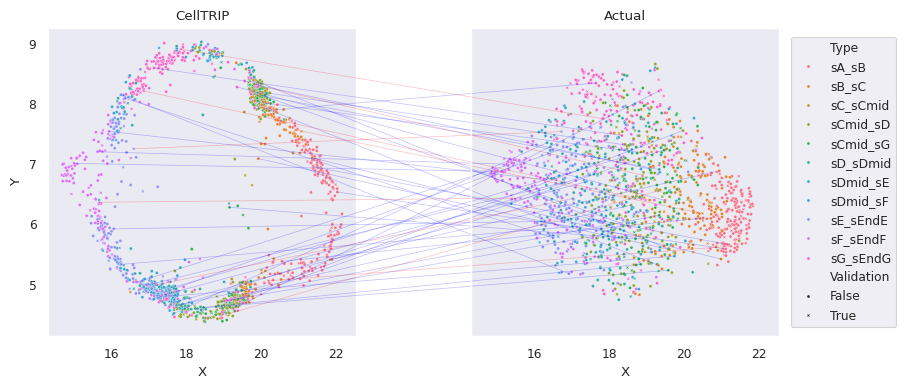

In [17]:
# Plot imputed vs actual
df = pd.DataFrame(index=samples)
df[['X_pred', 'Y_pred']] = reduction(inverse_transform(pinning_function(steady_state)))[..., :2]
# df[['X_pred', 'Y_pred']] = X_pred_new[..., :2]
df['Type'] = adatas[0].obs.loc[samples, 'traj_sim']
# 'target_gene', 'layer', 'pattern_gp_label', 'annotation',
# 'traj_sim', 'label', 'subclass, 'days', 'sgAssign',
# 'seurat_clusters', 'cell_type', 'bc1'
hue_order = df['Type'].sort_values().unique()
# Have target data
df[['X_true', 'Y_true']] = reduction(inverse_transform(target_state.numpy()))[..., :2]
df['Validation'] = ~pd.DataFrame(mask, index=adatas[0].obs.index).loc[samples]
# Don't have target data
# df[['X_true', 'Y_true']] = df[['X_pred', 'Y_pred']]
# df['Validation'] = True
# Additional
# df = df.loc[df['Validation']]
# Plot
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
sns.scatterplot(df, x='X_pred', y='Y_pred', hue='Type', hue_order=hue_order, style='Validation', s=5, legend=False, ax=axs[0])
sns.scatterplot(df, x='X_true', y='Y_true', hue='Type', hue_order=hue_order, style='Validation', s=5, legend=True, ax=axs[1])
axs[1].legend(ncols=np.ceil(len(df['Type'].unique())/15), loc='center left', bbox_to_anchor=(1.04, 0.5), borderaxespad=0)
for i in np.random.choice(df.shape[0], min(50, df.shape[0]), replace=False):
    patch = ConnectionPatch(
        xyA=df.iloc[i][['X_pred', 'Y_pred']].to_numpy(), xyB=df.iloc[i][['X_true', 'Y_true']].to_numpy(),
        coordsA='data', coordsB='data', axesA=axs[0], axesB=axs[1],
        color='blue' if not df.iloc[i]['Validation'] else 'red', lw=.5, alpha=.25)
    axs[1].add_patch(patch)
axs[0].set(title='CellTRIP', xlabel='X', ylabel='Y')
axs[1].set(title='Actual', xlabel='X')
axs[0].set_box_aspect(1)
axs[1].set_box_aspect(1)
# axs[1].set(xlim=[-10, 10], ylim=[-10, 10])
fig.show()


In [18]:
# Intra-type Error
# df['MSE'] = np.mean(np.square(inverse_transform(pred) - inverse_transform(target_state.numpy())), axis=-1)
df['MSE'] = np.mean(np.square(inverse_transform(pinning_function(steady_state)) - inverse_transform(target_state.numpy())), axis=-1)
df_mse = df[['Type', 'MSE']].groupby('Type', observed=True).mean()
df_mse['Training MSE'] = df.loc[~df['Validation'], ['Type', 'MSE']].groupby('Type', observed=True).mean()
df_mse['Validation MSE'] = df.loc[df['Validation'], ['Type', 'MSE']].groupby('Type', observed=True).mean()
df_mse


,MSE,Training MSE,Validation MSE
Type,,,
sA_sB,0.058519,0.056688,0.065988
sB_sC,0.057192,0.055174,0.067203
sC_sCmid,0.067401,0.066063,0.073253
sCmid_sD,0.052095,0.051046,0.055557
sCmid_sG,0.060664,0.060331,0.061635
sD_sDmid,0.066587,0.063794,0.080953
sDmid_sE,0.089490,0.084864,0.107817
sDmid_sF,0.088083,0.085598,0.098955
sE_sEndE,0.176801,0.169485,0.206069


In [19]:
%%manim -qm -v WARNING LatentSpaceVisualization

positions = (
    sklearn.decomposition
    .PCA(n_components=2)
    .fit(steady_state[:100])
    .transform(
        ret[-1].cpu()[..., :100, :env.dim]
        .reshape((-1, env.dim)))
    .reshape((*ret[-1].shape[:-1], 2)))
speedup = 100

class LatentSpaceVisualization(ma.Scene):
    def construct(self):
        # Axes
        spread = 50
        ax = ma.Axes(
            x_range=[-spread, spread, 10], y_range=[-spread, spread, 10],
            x_length=7, y_length=7, tips=False)
        self.add(ax)

        # Time
        t = ma.ValueTracker(0)

        # Dot
        def dot_updater(i):
            return lambda x: x.move_to(ax.c2p(*positions[int(t.get_value()), i]))
        for i in range(positions.shape[1]):
            dot = ma.Dot(
                ax.c2p(*positions[0, i]),
                radius=.02)
            dot.add_updater(dot_updater(i))
            self.add(dot)

        # Animate
        self.play(t.animate.set_value(ret[-1].shape[0]-1), rate_func=ma.linear, run_time=positions.shape[0]*env.delta/speedup)


ValueError: cannot reshape array of size 2800 into shape (14,1500,2)

In [ ]:
assert False


In [ ]:
# Preliminaries
import ot
def transform_and_center(X):
    trans_X = sklearn.decomposition.PCA().fit_transform(X)
    return trans_X - trans_X.mean(axis=0)

# Get OT matrix
stages = ['L1_a', 'L2_a', 'L3_b']
np.random.seed(42)
start_idx = np.random.choice((adatas[0].obs['development'] == stages[0]).sum(), 1_000, replace=False)  # Subsample
end_idx = np.random.choice((adatas[0].obs['development'] == stages[-1]).sum(), 1_000, replace=False)
# start_idx = end_idx = list(range(1_000))  # This way just does first few slices
start_exp = adatas[0][np.argwhere(adatas[0].obs['development'] == stages[0])[start_idx]].X
end_exp = adatas[0][np.argwhere(adatas[0].obs['development'] == stages[-1])[end_idx]].X
start_types = adatas[0].obs.loc[adatas[0].obs['development'] == stages[0], 'annotation'].iloc[start_idx]
end_types = adatas[0].obs.loc[adatas[0].obs['development'] == stages[-1], 'annotation'].iloc[end_idx]
start_obs = transform_and_center(adatas[1][np.argwhere(adatas[0].obs['development'] == stages[0])[start_idx]].X)  # Argwhere needed b/c of AnnCollection
end_obs = transform_and_center(adatas[1][np.argwhere(adatas[0].obs['development'] == stages[-1])[end_idx]].X)
a, b = ot.utils.unif(start_obs.shape[0]), ot.utils.unif(end_obs.shape[0])
M = ot.dist(start_obs, end_obs)
M /= M.max()
G0 = ot.emd(a, b, M, numItermax=1_000_000)
# Gs = ot.sinkhorn(a, b, M, 1e-1)


In [ ]:
# Get pseudocells
# pcells = [([], [])]  # TODO
pcells = [([i], np.argwhere(G0[i] > 0).flatten()) for i in range(G0.shape[0]) if G0[i].sum() > 0]
pcells_start_exp, pcells_end_exp = [], []
for pcell_start, pcell_end in pcells:
    pcells_start_exp.append(start_exp[pcell_start].mean(axis=0))
    pcells_end_exp.append(end_exp[pcell_end].mean(axis=0))
pcells_start_exp = np.stack(pcells_start_exp, axis=0)
pcells_end_exp = np.stack(pcells_end_exp, axis=0)


In [ ]:
# Create env
m1_start, = preprocessing.transform(pcells_start_exp, subset_modality=0)
m1_end, = preprocessing.transform(pcells_end_exp, subset_modality=0)
env = celltrip.environment.EnvironmentBase(
    torch.tensor(m1_start), target_modalities=None, compute_rewards=False, dim=8).eval().to('cuda')

# Get transition states
env.reset()
celltrip.train.simulate_until_completion(env, policy, store_states=False)  # Set env at steady state
env.time = 0  # Reset timing
env.set_modalities([torch.tensor(m1_end)]).to('cuda')  # Set to ending expression
transition_states = celltrip.train.simulate_until_completion(env, policy, store_states=True)[-1][..., :env.dim].cpu()
start_pred, mid_pred, end_pred = transition_states[0], transition_states[50], transition_states[-1]  # TODO Better method than 50


In [ ]:
# TODO - Remove or notate 1M prepro limit


In [ ]:
# Get types
types = [[start_types.iloc[pcell[0]].tolist() for pcell in pcells], [end_types.iloc[pcell[1]].tolist() for pcell in pcells]]
types = [stt+ent for stt, ent in zip(*types)]
types = [max(set(tl), key=tl.count) for tl in types]

# Plot
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(15, 4))
for i, (ax, pred) in enumerate(zip(axs, [start_pred, mid_pred, end_pred])):
    df = pd.DataFrame(index=list(range(len(pcells))))
    df[['x', 'y', 'z']], = preprocessing.inverse_transform(policy.pinning[0](pred.cuda()).cpu().detach().numpy(), subset_modality=1)
    df['Type'] = types
    sns.scatterplot(df, x='x', y='y', hue='Type', hue_order=hue_order, legend=i==2, ax=ax)
    # Formatting
    if not i == 1: ax.set_title(f'{stages[i]}')
    else: ax.set_title(f'{stages[i]} (interpolated)')
    ax.set(xlabel=None, ylabel='CellTRIP')
    ax.set_box_aspect(1)
axs[-1].legend(ncols=np.ceil(len(df['Type'].unique())/15), loc='center left', bbox_to_anchor=(1.04, 0.5), borderaxespad=0)


In [ ]:
# Calculate correlations
Y_pred = inverse_transform(pinning_function(steady_state))
Y_true = inverse_transform(target_state.numpy())
record = {'gene': [], 'corr': [], 'p': []}
for i in range(Y_true.shape[1]):
    res = scipy.stats.pearsonr(Y_pred[:, i], Y_true[:, i])
    corr, p = res.statistic, res.pvalue
    record['gene'].append(adatas[0].var.index[i])
    record['corr'].append(corr)
    record['p'].append(p)
df = pd.DataFrame(record)
sig_frac = (df.dropna()['p'] <= 5e-2).mean()
print(f'{100*sig_frac:.0f}% significant correlations')

# Distribution plot
df_sort = df.dropna().sort_values('corr', ascending=False)
fig, axs = plt.subplots(2, 1, figsize=(5, 4), sharex=True)
axs[0].plot(df_sort['gene'], df_sort['corr'], color='black')
axs[0].set(ylabel='Pearson')
axs[1].plot(df_sort['gene'], df_sort['p'], color='black')
axs[1].set(ylabel='p-value', xlabel='Gene', xticks=[])
axs[1].axhline(y=5e-2, ls='--', color='black')

# Specific scatter
# idx = df['corr'].sort_values().dropna().iloc[::-1].index[0]
idx = np.argwhere(df['gene'] == 'TMSB4X').flatten()[0]
# idx = np.argwhere(df['gene'] == 'TADA1').flatten()[0]
# idx = np.argwhere(df['gene'] == 'PRCP').flatten()[0]
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
# Main scatter
ax.scatter(Y_true[:, idx], Y_pred[:, idx], s=1, color='black')
# Extra text
corr, p = df.iloc[idx][['corr', 'p']]
ax.text(.01, .99, f'Pearson: {corr:.3f}\np-value: {p:.2e}', ha='left', va='top', transform=ax.transAxes)
# Add y=x line
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),
    np.max([ax.get_xlim(), ax.get_ylim()])]
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set(title=adatas[0].var.index[idx], xlabel='Observed', ylabel='CellTRIP')


In [ ]:
ret[-1][-1][..., env.dim:].mean(dim=0)


In [ ]:
steady_state.mean(dim=0)


In [ ]:
def gene_perturbation(adata, steady_state, genes_to_perturb, preprocessing, modality=0, factor=0):  # adatas[0][samples_flt1], max_steps=1_000
    # Set up env
    env.reset()
    env.set_positions(steady_state.to(env.device))
    env.set_velocities(0*env.get_velocities())
    # Find feature
    features = [np.argwhere(adata.var.index == gene).flatten()[0] for gene in genes_to_perturb]
    # Get knockdowns
    iso_modality = preprocessing.transform(adata.X[:], subset_features=features, subset_modality=modality)[0]  # TODO: Send to pramod with [:] addition
    iso_modality = torch.tensor(iso_modality).to(env.device)
    env.modalities[modality] -= iso_modality - factor*iso_modality
    # Simulate
    ret = celltrip.train.simulate_until_completion(env, policy, store_states=True)

    return ret[-1]

# Permute
group_pert = gene_perturbation(adatas[0][samples], steady_state, ['TMSB4X'], preprocessing, modality=0, factor=0)

# Plot imputed vs actual
df = pd.DataFrame(index=samples)
df[['X_init', 'Y_init']] = reduction(inverse_transform(pinning_function(group_pert[0, :, :env.dim])))[..., :2]
df[['X_final', 'Y_final']] = reduction(inverse_transform(pinning_function(group_pert[-1, :, :env.dim])))[..., :2]
df['Type'] = adatas[0].obs.loc[samples, 'target_gene']  # 'target_gene', 'layer', 'pattern_gp_label', 'annotation'
df['Validation'] = ~pd.DataFrame(mask, index=adatas[0].obs.index).loc[samples]
# df = df.loc[df['Validation']]
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
sns.scatterplot(df, x='X_init', y='Y_init', hue='Type', style='Validation', legend=False, ax=axs[0])
sns.scatterplot(df, x='X_final', y='Y_final', hue='Type', style='Validation', legend=True, ax=axs[1])
for i in np.random.choice(df.shape[0], min(50, df.shape[0]), replace=False):
    patch = ConnectionPatch(
        xyA=df.iloc[i][['X_init', 'Y_init']].to_numpy(), xyB=df.iloc[i][['X_final', 'Y_final']].to_numpy(),
        coordsA='data', coordsB='data', axesA=axs[0], axesB=axs[1],
        color='blue' if not df.iloc[i]['Validation'] else 'red', lw=.5, alpha=.25)
    axs[1].add_patch(patch)
axs[0].set(title='Steady State', xlabel='X', ylabel='Y')
axs[1].set(title='Perturbed (TMSB4X)', xlabel='X')
fig.show()


In [ ]:
# Permute
start_state = steady_state.clone()
start_state[0] = start_state[600]  # 600 for VCC, 1 for MERFISH
# Set to steady state
env.reset()  # .store_vals().set_termination_conds(exclusive=True, max_time=True) ; env.max_time = 10
env.set_velocities(0*env.get_velocities())
env.set_positions(start_state.to('cuda'))
# Run and reset
ret = celltrip.train.simulate_until_completion(env, policy, store_states=True)
transition_states = ret[-1][..., :env.dim].cpu()

# Convert select points to feature space
use_states = list(map(int, np.linspace(0, transition_states.shape[0]-1, 9)))
filtered_transition_states = transition_states[use_states]
pinned_transition_states = reduction(
    inverse_transform(
        pinning_function(
            filtered_transition_states.reshape((-1, env.dim))
        )
    )
).reshape((*filtered_transition_states.shape[:-1], -1))

# Get timepoints
dfs = []
for i, timepoint in enumerate(use_states):
    timepoint = int(timepoint)
    dfs.append(pd.DataFrame(index=samples))
    dfs[-1][['X', 'Y']] = pinned_transition_states[i]
    dfs[-1]['Type'] = adatas[0].obs.loc[samples, 'target_gene']
    dfs[-1]['Timepoint'] = timepoint
    dfs[-1]['Perturbed'] = False
    dfs[-1].loc[samples[0], 'Perturbed'] = True
df = pd.concat(dfs, axis=0)
# Plot
fig, axs = plt.subplots(3, 3, figsize=(15, 6), sharex=True, sharey=True)
axs = axs.flatten()
unique_timepoints = df['Timepoint'].unique()
target_point = 0; target_point_positions = []
for i, timepoint in enumerate(unique_timepoints):
    df_filter = df.loc[df['Timepoint'] == timepoint]
    target_point_positions.append(df_filter.loc[[samples[target_point]]])
    sns.scatterplot(df_filter, x='X', y='Y', hue='Type', alpha=.4, legend=False, ax=axs[i])
    for j in range(i):
        axs[i].arrow(
            *target_point_positions[j][['X', 'Y']].to_numpy().flatten(),
            *(target_point_positions[j+1][['X', 'Y']].to_numpy() - target_point_positions[j][['X', 'Y']].to_numpy()).flatten(),
            color='red', lw=1)
    sns.scatterplot(df_filter.loc[[samples[target_point]]], x='X', y='Y', color='blue', alpha=1., legend=False, ax=axs[i])
    axs[i].set(title=f'{timepoint*env.delta:.1f}s', xlabel='X', ylabel='Y')
fig.show()


In [ ]:
assert False


# Running out-of-scope data

In [ ]:
# Load the external dataset
adata = celltrip.utility.processing.read_adatas(
    # 's3://nkalafut-celltrip/MERFISH_Bench/expression.h5ad', backed=True)[0]
    '../data/MERFISH_Bench/sc_data.h5ad', backed=True)[0]
# Generate or load preprocessing
preprocessing = celltrip.utility.processing.Preprocessing().load(f'{prefix}.pre')
# Subset and preprocess the data (Use partition cols here to select data)
samples = adata.obs.index
m1, = preprocessing.transform(adata[samples].X, subset_modality=0)
# Initialize environment and policy
env = celltrip.environment.EnvironmentBase(
    torch.tensor(m1), target_modalities=None, dim=8).eval().to('cuda')
# env.set_modalities(...); env.reset()  # Change modalities
policy = celltrip.policy.create_agent_from_env(env, pinning_modal_dims=[2]).eval().to('cuda')  # pinning=False for lstq pinning
policy.load_checkpoint(f'{prefix}-{training_step:04}.weights');


In [ ]:
# Run policy to convergence
env.disable_rewards(); env.reset()
ret = celltrip.train.simulate_until_completion(env, policy, store_states=True)
steady_state = ret[-1][-1][:, :env.dim].cpu()
# Get pinning and inverse
pinning_function = lambda X: policy.pinning[0](X.to('cuda')).detach().cpu().numpy()
inverse_transform = lambda X: preprocessing.inverse_transform(X, subset_modality=1)[0]


In [ ]:
# inverse_transform = lambda X: X


In [ ]:
# Plot imputed
df = pd.DataFrame(index=samples)
df[['X_pred', 'Y_pred']] = inverse_transform(pinning_function(steady_state))[..., :2]
df[['X_true', 'Y_true']] = adata.obs['spot'].str.split('x', expand=True).astype(float)
df['Type'] = adata.obs['cellType']  # pattern_gp_label, HMRF_k3_b.40
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
sns.scatterplot(df, x='X_pred', y='Y_pred', hue='Type', legend=False, ax=axs[0])
sns.scatterplot(df, x='X_true', y='Y_true', hue='Type', legend=True, ax=axs[1])
axs[0].set(title='CellTRIP', xlabel='X', ylabel='Y')
axs[1].set(title='Actual', xlabel='X')
fig.show()
